In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn
import squidpy as sq
import stuf as uf

/opt/homebrew/Caskroom/miniforge/base/envs/stuf_docs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/stuf_docs/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
adata = sc.read_h5ad("E11_demo_3_072625.h5ad")
adx = adata.copy()

In [3]:
min_cells = 10
sc.pp.filter_genes(adx, min_cells=min_cells)

In [4]:
adx.layers['counts'] = adx.X.copy()
sc.pp.log1p(adx)

In [5]:
sc.pp.highly_variable_genes(adx, n_top_genes=2000, flavor='cell_ranger')

In [6]:
sq.gr.spatial_neighbors(adx,spatial_key='X_spatial')
sq.gr.spatial_autocorr(adx, mode="moran")
threshold = 0.25
uf.ut.annotate_spatially_variable_genes(adx, pval_column="pval_norm_fdr_bh", pval_cutoff=threshold)

In [7]:
uf.tl.build_gene_knn_graph(adx, mask_var='spatially_variable', mean_cluster=False, metric='correlation', knn=10)

In [8]:
gene = "Tubb3"
gl_tubb3 = uf.tl.find_similar_genes(adx, gene, 10, use='distances')
print(gl_tubb3)

['Tuba1a', 'Stmn2', 'Ina', 'Dcx', 'Map1b', 'Crmp1', 'Dpysl3', 'Tubb2b', 'Nefl']


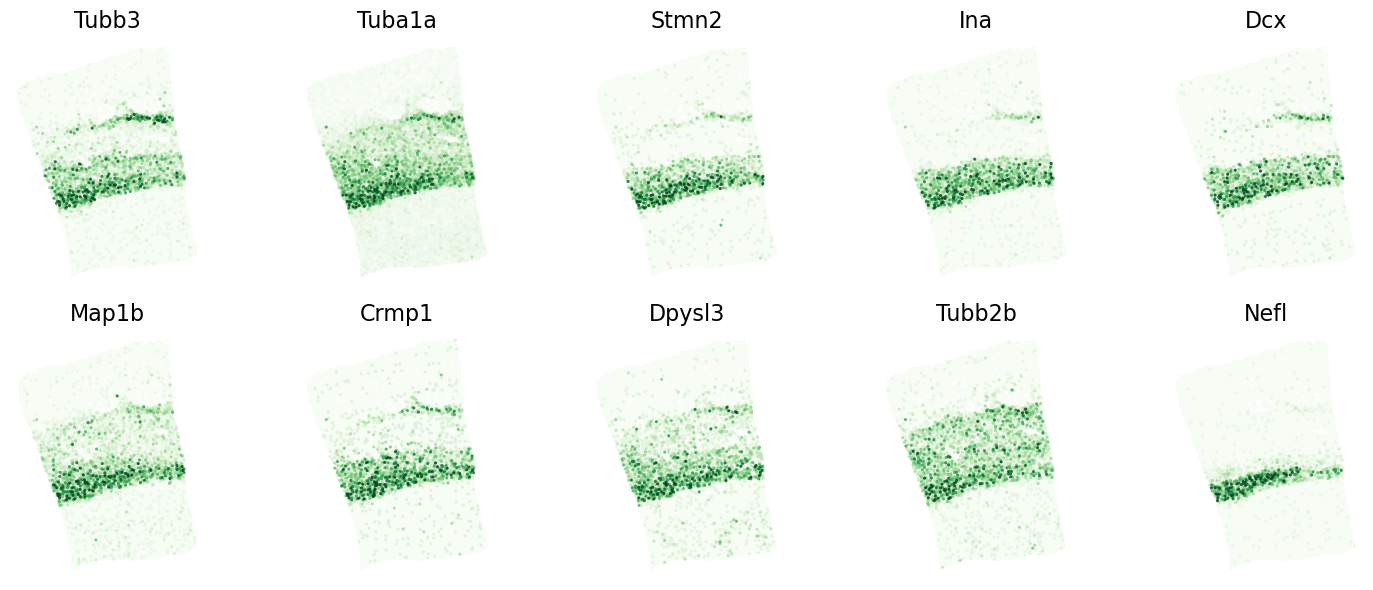

In [9]:
n_cols = 5
n_rows = 2
ngenes = 10

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3, n_rows * 3),
    squeeze=False
)
axes_flat = axes.ravel()

for ax, gene in zip(axes_flat, ["Tubb3"] + gl_tubb3 ):
    uf.pl.embed_geneset(
        adata,
        genes=[gene],
        ax=ax,
        show_colorbar=False,    
        show_gene_names=False,
        scatter_kwargs={'s': 5, 'cmap': 'Greens'}
    )
    ax.set_title(gene,fontsize=16)

# turn off any leftover axes
for ax in axes_flat[ngenes:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

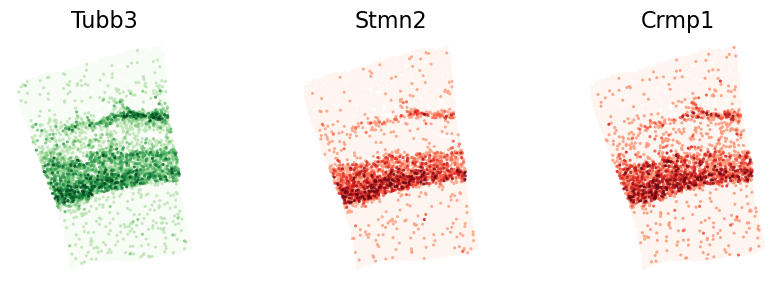

In [10]:
layout = [["A", "B", "C"]]
figsize=(9, 3)
fig, axes = plt.subplot_mosaic(
    layout,
    figsize=figsize
)

# query gene
uf.pl.embed_geneset(adx, genes=['Tubb3'], ax=axes['A'], show_gene_names=False, show_colorbar=False, scatter_kwargs={'s': 5, 'cmap': 'Greens'})
axes["A"].set_title("Tubb3", fontsize=16)

# answer genes
for key, gene in zip(["B","C"], ["Stmn2", "Crmp1"]):
    uf.pl.embed_geneset(adx, genes=[gene], ax=axes[key], show_gene_names=False, show_colorbar=False, scatter_kwargs={'s': 5, 'cmap': 'Reds'})
    axes[key].set_title(gene, fontsize=16)

plt.tight_layout()
plt.show()

In [12]:
ssize = 3
gene = "Sox2"
gl_sox2 = uf.tl.find_similar_genes(adx, gene, 10, use='distances')
print(gl_sox2)

['Fabp7', 'Ckb', 'Vim', 'Msx3', 'Hes5', 'Hoxb9', 'Zic1', 'Fzd10', 'Cenpf']


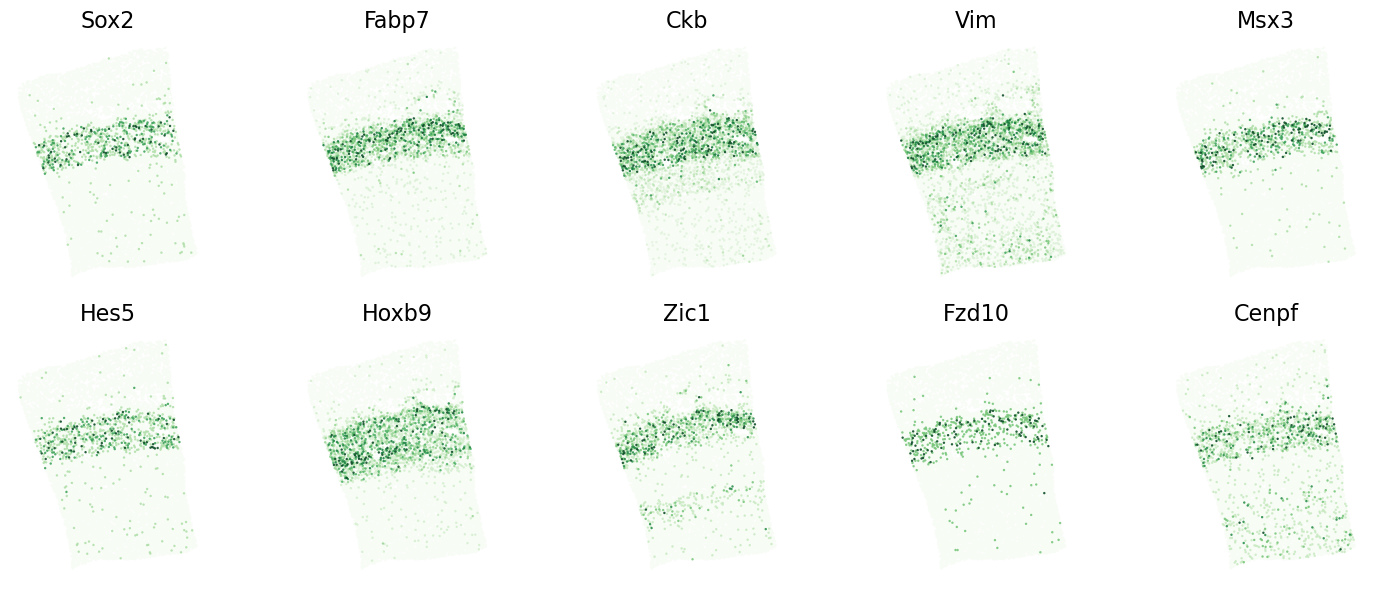

In [13]:
n_cols = 5
n_rows = 2
ngenes = 10

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 3, n_rows * 3),
    squeeze=False
)
axes_flat = axes.ravel()

for ax, gene in zip(axes_flat, ["Sox2"] + gl_sox2 ):
    uf.pl.embed_geneset(
        adata,
        genes=[gene],
        ax=ax,
        show_colorbar=False,    
        show_gene_names=False,  
        scatter_kwargs={'s': ssize, 'cmap': 'Greens'}
    )
    ax.set_title(gene,fontsize=16)

for ax in axes_flat[ngenes:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

/Users/pcahan/Dropbox (Personal)/Code/stuf/src/stuf/plotting/embed.py:120: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(xy[:,0], xy[:,1], c=[hexcols[i] for i in order], **skw)


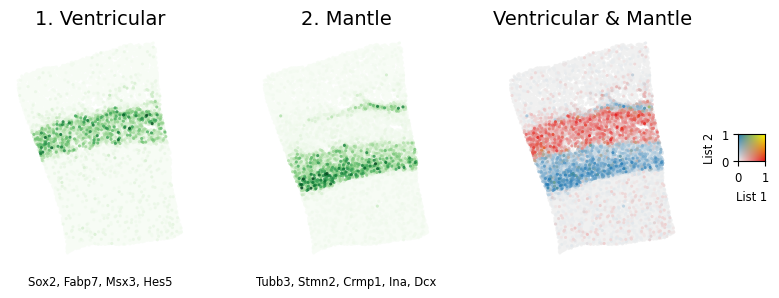

In [14]:
gl_sox2 = ["Sox2", "Fabp7", "Msx3", "Hes5"]
gl_tubb3 = ["Tubb3", "Stmn2", "Crmp1", "Ina", "Dcx"]

ssize = 5
layout = [["left", "center", "right"]]
fig, axes = plt.subplot_mosaic(layout,figsize=(9, 3)) # ,gridspec_kw={'wspace': 0.0, 'hspace': 0.05})

gene = "Sox2"
uf.pl.embed_geneset(adata,
    genes=gl_sox2,
    ax=axes["left"],
    log1p=False,
    show_colorbar=False,
    show_gene_names=True,#False,
    scatter_kwargs={'s': ssize, 'cmap': 'Greens'}
)
axes["left"].set_title("1. Ventricular", fontsize=14)

gene = "Tubb3"
uf.pl.embed_geneset(adata,
    genes=gl_tubb3,
    ax=axes["center"],
    log1p=False,
    show_colorbar=False,
    show_gene_names=True,#False,
    scatter_kwargs={'s': ssize, 'cmap': 'Greens'}
)
axes["center"].set_title("2. Mantle", fontsize=14)

uf.pl.embed_bivariate_genes(adata,
    genes1=gl_sox2, genes2=gl_tubb3,
    scatter_kwargs={'s':ssize},
    ax=axes['right'],
    show_legend=True,
    clip_percentiles=(0,99),
    list_genes=False,
    cbar_kwargs={'width':'15%','height':'80%','loc':'center right', 'borderpad':-6}
)
axes["right"].set_title("Ventricular & Mantle", fontsize=14)

plt.show()

In [15]:
ad2 = adx.copy()
uf.ut.rotate_coordinates(ad2, "X_spatial", 100)
ad3 = ad2.copy()
uf.ut.flip_coordinates(ad3, "X_spatial", 'y')

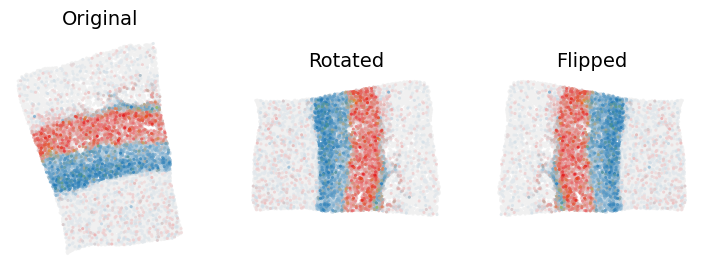

In [17]:
gl_sox2 = ["Sox2", "Fabp7", "Msx3", "Hes5"]
gl_tubb3 = ["Tubb3", "Stmn2", "Crmp1", "Ina", "Dcx"]

ssize = 5
layout = [["left", "center", "right"]]
fig, axes = plt.subplot_mosaic(layout, figsize=(9, 3))

for key, title, ad in zip(
    ["left", "center", "right"],
    ["Original", "Rotated", "Flipped"],
    [adx, ad2, ad3]
):
    uf.pl.embed_bivariate_genes(
        ad,
        genes1=gl_sox2, genes2=gl_tubb3,
        scatter_kwargs={'s': ssize},
        ax=axes[key],
        show_legend=False,
        clip_percentiles=(0, 99),
        list_genes=False
    )
    axes[key].set_title(
        title,
        fontsize=14,
    )

# shrink top margin so titles aren’t clipped
# fig.subplots_adjust(top=0.85)

plt.show()

In [18]:
kname = "contour_sox2"
uf.tl.contourize(ad3,genes=gl_sox2, contour_levels=3,spatial_key="X_spatial",grid_res=200, log_transform=False, clip_percentiles=(1,95), annotation_key=kname, smooth_sigma=6)

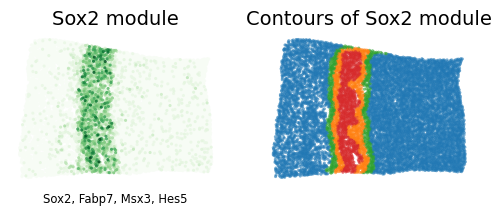

In [19]:
ssize = 5
fig, (ax_expr, ax_cat) = plt.subplots(1, 2, figsize=(6, 3))

uf.pl.embed_geneset(ad3, genes = gl_sox2, embedding_key='X_spatial', scatter_kwargs={'s':ssize, 'cmap':'Greens'}, ax=ax_expr,  show_colorbar=False)
ax_expr.set_title("Sox2 module", fontsize=14)


uf.pl.embed_categorical(ad3, category_key = kname, embedding_key='X_spatial', scatter_kwargs={'s':ssize}, ax=ax_cat, show_legend=False)
ax_cat.set_title("Contours of Sox2 module", fontsize=14)
plt.show()